1. 데이터 준비   
 1.1 csv데이터   


In [1]:
# PATH변경
import pandas as pd
label_df = pd.read_csv('./Dataset/train.csv')
label_df.head()

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


 1.2 이미지 데이터

In [2]:
import os
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    #print(glob(os.path.join(data_dir,'*.PNG')))
    # /로 짤린 것 중에서 맨 뒤( *.PNG) + 거기서 '.'으로 나뉘는 파일이름으로 정렬
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(label_df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x : int(x.split('/')[-1].split('.')[0]) )

    return img_path_list


2. 데이터 확인
 2. 1 csv 데이터

In [3]:
print(label_df.head())
label_df.info()


  file_name  label
0   001.PNG      9
1   002.PNG      4
2   003.PNG      1
3   004.PNG      1
4   005.PNG      6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  723 non-null    object
 1   label      723 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


   2.2 이미지 데이터

In [4]:
all_img_path, all_label = get_train_data('./Dataset/train')
test_img_path = get_test_data('./Dataset/test')
print(all_img_path[:5])
print(all_label[:5])

classes = ('63 Building', 'Namsan Tower', 'Gyeongbokgung Palace', 'Gwangjang Market', 'Hyundai Department Store', 'Ttukseom Hangang Park', 'Lotte World Tower', 'Bongeunsa Temple', 'Bukchon Hanok Village', 'Seoul Forest')

['./Dataset/train/001.PNG', './Dataset/train/002.PNG', './Dataset/train/003.PNG', './Dataset/train/004.PNG', './Dataset/train/005.PNG']
[9, 4, 1, 1, 6]


3. 환경설정   
데이터를 전처리 하기 위한 GPU 환경설정

In [5]:
import torch
import torch.nn as nn
# 병렬화 비활성화
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
# GPU를 정렬 , 0번 부터
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # Arrange GPU devices starting from 0
# 사용하고자 하는 GPU빼고 나머지 제한
#os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Set the GPU 2 to us, multi gpu
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')


cuda:1
torch version : 1.12.1


In [6]:
# GPU 체크 및 할당
if torch.cuda.is_available():
    print('Device :',device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU :', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

Device : cuda:1
There are 2 GPU(s) available.
We will use the GPU : NVIDIA GeForce RTX 3090 Ti


In [7]:
import numpy as np
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(41)

데이터 전처리   
CustomDataset

In [8]:
import torchvision.datasets as datasets # 데이터셋 
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self,index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

    

In [9]:
# import matplotlib.font_manager as fm

# font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')

# font_list[:]

CustomDataset으로 만든 Data확인

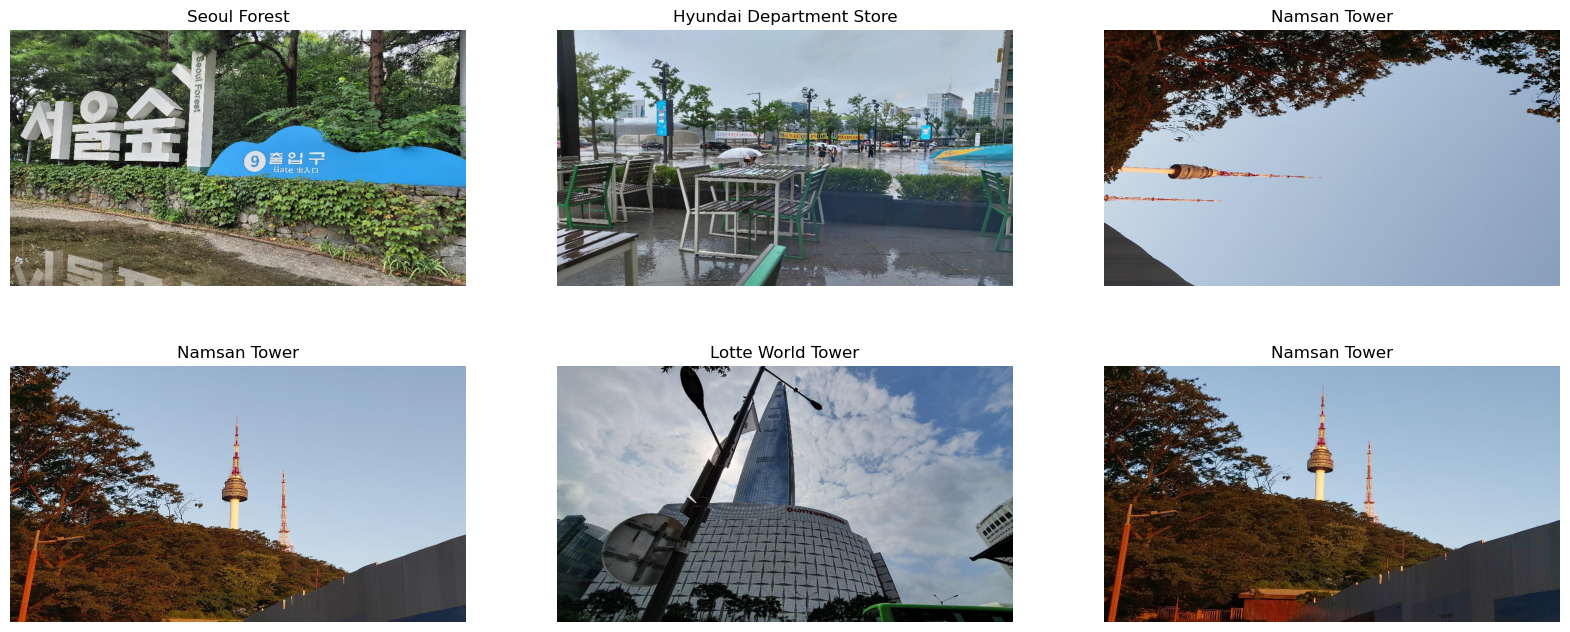

In [10]:
temp_dataset = CustomDataset(all_img_path,all_label, train_mode=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(temp_dataset.__getitem__(i)[0][...,::-1])
    plt.title(classes[temp_dataset.__getitem__(i)[1]])
    plt.axis('off')

전체 이미지 mean과 std 구하기

In [11]:
# 모든 이미지의 사이즈 확인
# mean과 std 구하기
import numpy as np
temp_transform = transforms.Compose([
    transforms.ToTensor(), # tensor로 변경
])
temp_dataset = CustomDataset(
    all_img_path,all_label, train_mode=False, transforms=temp_transform)

def find_info(dataset):
    img_size = []
    img_mean = np.empty((0,3))
    img_std = np.empty((0,3))
    #print(len(dataset)) -> 723개
    for i in range(len(dataset)):
        img = dataset.__getitem__(i)
        m = np.mean(np.array(img),axis=(1,2))
        s = np.std(np.array(img),axis=(1,2))
        img_mean = np.append(img_mean,[m],axis=0)
        img_std = np.append(img_std,[s],axis=0)
        #print(np.array(img).shape) # 3,540,960
        #print(img_mean.shape)      # (3,)
        #print(img_std.shape)       # (3,)

        if img.shape not in img_size:
            img_size.append(img.shape)
    #print(img_mean.shape)
    mean_r = round(np.mean(img_mean[:,0]),3)
    mean_g = round(np.mean(img_mean[:,1]),3)
    mean_b = round(np.mean(img_mean[:,2]),3)
    mean = (mean_r, mean_g, mean_b)
    
    std_r = round(np.mean(img_std[:,0]),3)
    std_g = round(np.mean(img_std[:,1]),3)
    std_b = round(np.mean(img_std[:,2]),3)
    std = (std_r,std_g,std_b)

    return img_size, mean, std

#img_size, img_mean, img_std = find_info(temp_dataset)
img_size = [[3,540,960]]
img_mean = (0.475, 0.470, 0.458)
img_std = (0.295, 0.264, 0.254)
print(f'img_size = {img_size}')
print(f'img mean = {img_mean}')
print(f'img std = {img_std}')


img_size = [[3, 540, 960]]
img mean = (0.475, 0.47, 0.458)
img std = (0.295, 0.264, 0.254)


Train / Validation split   
전체 데이터에서 분리

In [12]:
train_len = int(len(all_img_path)*0.7)
val_len = int(len(all_img_path)*0.3)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

val_img_path = all_img_path[train_len:]
val_label = all_label[train_len:]

In [13]:
print(f'train set 크기 : {len(train_img_path)}')
print(f'val set 크기 : {len(val_img_path)}')

train set 크기 : 506
val set 크기 : 217


하이퍼 파라미터 값 설정

In [14]:
CFG = {
    'IMG_SIZE':256,
    'CROP_SIZE':224,
    'EPOCHS':200,
    'BATCH_SIZE':16,
}

Transform

In [15]:
import torchvision.transforms.functional as TF
from typing import Sequence

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)


train_transform = transforms.Compose([
    transforms.ToPILImage(), # numpy --> PIL로 변경
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]), #128 * 128이미지로 사이즈변경
    transforms.RandomAffine(20),
    transforms.CenterCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(), # tensor로 변경
    transforms.Normalize(mean=img_mean, std=img_std), # 이미지 정규화 
    #MyRotateTransform([-90,0,90]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]),
    transforms.CenterCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

DataLoader

In [16]:
train_dataset = CustomDataset(
    train_img_path, 
    train_label,
    train_mode=True,
    transforms=train_transform
    )
train_loader = DataLoader(
    train_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=True
)

val_dataset = CustomDataset(
    val_img_path,
    val_label,
    train_mode=True,
    transforms=test_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=False
)

In [17]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print(f'total train imgs : {train_len} / total train batches :{train_batches}')
print(f'total val imgs : {val_len} / total val batches :{val_batches}')

total train imgs : 506 / total train batches :32
total val imgs : 216 / total val batches :14


torch.Size([16, 3, 224, 224])


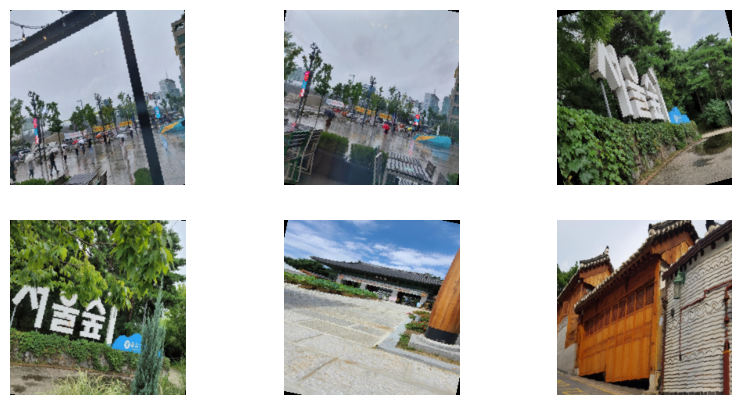

In [18]:
img, _ = next(iter(train_loader))
print(img.shape)
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    k = img[i] * torch.tensor(img_std).view(3, 1, 1) + torch.tensor(img_mean).view(3, 1, 1)
    plt.imshow(k.detach().cpu().numpy().transpose(1,2,0)[...,::-1])
    plt.axis('off')

Model 정의

In [19]:
import torch.nn as nn
from tqdm import tqdm
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 1000)
        self.fc2 = nn.Linear(1000,num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        self.initialize_weights()

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.fc2(x)

        return x

    def initialize_weights(self):
        # track all layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [20]:
resnet50 = ResNet(num_classes=10)
resnet101 = ResNet(layers=[3, 4, 23, 3], num_classes=10)

import torchsummary
torchsummary.summary(resnet50,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
from torchvision import models
from torchvision.models import efficientnet_b0 
import torch.nn as nn
from torch.nn import functional as F

effi_net = efficientnet_b0()

print(effi_net.classifier)

in_eff = 1280

e_classifier=nn.Sequential(
    nn.Linear(in_eff,1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000,10),

)
# 기본 모델은 fc 마지막이 1000개의 분류 , 맞춰주어야한다
effi_net.classifier = e_classifier


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


Model 학습

In [22]:
def train(model,optimizer,criterion, train_loader, scheduler,device,name):
    model.to(device)
    n = len(train_loader)
    best_acc = 0
    count = 1
    best_loss = 100
    history = {}
    history['train_loss'] =[]
    history['train_acc'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    history['class_correct'] = []

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        running_loss = 0.0
        train_acc = 0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            output = model(img)
            loss = criterion(output,label)

            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
            
            _, output = torch.max(output,1)
            train_acc += (output == label).sum().item()

        train_acc = 100*train_acc/ len(train_loader.dataset)
        train_loss = running_loss/len(train_loader)
        print(f'{epoch} Train loss : {train_loss:.5f}')

        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = {classname : 0 for classname in classes}
        class_total = {classname : 0 for classname in classes}


        with torch.no_grad():
            for img, labels in tqdm(iter(val_loader)):
                img, labels = img.to(device), labels.to(device)

                outputs = model(img)
                val_loss += criterion(outputs,labels).item()
                # 가장 높은 것을 예측

                _, predicted = torch.max(outputs,1)
        
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for label, predict in zip(labels,predicted):
                    if label == predict:
                        class_correct[classes[label]] +=1
                    class_total[classes[label]] +=1
                    
        val_acc = 100* correct / total
        val_loss = val_loss/len(val_loader)

        print(f'Val loss : {val_loss:.4f}, Acc : {correct}/{len(val_loader.dataset)} :{100*correct/len(val_loader.dataset):.1f}')
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['class_correct'].append(class_correct)
 
        if best_loss < val_loss:
            if count > 5:
                print('Early stopping')
                break
            count +=1
        else:
            best_loss = val_loss

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            },f'./checkpoint/best_{name}.pth')
            print('Model Saved')
            count = 1
            
    return history

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=resnet50.parameters(), lr=0.005,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.2)
r_50_history=train(resnet50,optimizer,criterion,train_loader, scheduler, device, 'resnet50')

100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


1 Train loss : 2.49783


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


Val loss : 96.8466, Acc : 21/217 :9.7
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


2 Train loss : 2.20188


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Val loss : 2.8772, Acc : 64/217 :29.5
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


3 Train loss : 1.62356


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


Val loss : 1.7364, Acc : 90/217 :41.5
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


4 Train loss : 1.13020


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 1.2279, Acc : 126/217 :58.1
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


5 Train loss : 0.95805


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


Val loss : 1.1046, Acc : 143/217 :65.9
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


6 Train loss : 0.73932


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.8451, Acc : 155/217 :71.4
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


7 Train loss : 0.92487


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


Val loss : 1.1880, Acc : 157/217 :72.4


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


8 Train loss : 0.87874


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


Val loss : 1.0783, Acc : 161/217 :74.2


100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


9 Train loss : 0.58518


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


Val loss : 0.4510, Acc : 193/217 :88.9
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


10 Train loss : 0.35295


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


Val loss : 0.3023, Acc : 198/217 :91.2
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


11 Train loss : 0.21057


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.2451, Acc : 206/217 :94.9
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


12 Train loss : 0.19563


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.2329, Acc : 201/217 :92.6
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


13 Train loss : 0.12159


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1984, Acc : 207/217 :95.4
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


14 Train loss : 0.12954


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


Val loss : 0.1936, Acc : 206/217 :94.9
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


15 Train loss : 0.11860


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1928, Acc : 204/217 :94.0
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


16 Train loss : 0.10759


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1899, Acc : 208/217 :95.9
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


17 Train loss : 0.12559


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1816, Acc : 205/217 :94.5
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


18 Train loss : 0.11004


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


Val loss : 0.1784, Acc : 207/217 :95.4
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


19 Train loss : 0.10514


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Val loss : 0.2165, Acc : 206/217 :94.9


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


20 Train loss : 0.08125


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


Val loss : 0.1723, Acc : 207/217 :95.4
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


21 Train loss : 0.07113


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1664, Acc : 208/217 :95.9
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


22 Train loss : 0.08813


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


Val loss : 0.1720, Acc : 207/217 :95.4


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


23 Train loss : 0.09167


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Val loss : 0.1672, Acc : 209/217 :96.3


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


24 Train loss : 0.07201


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


Val loss : 0.1574, Acc : 207/217 :95.4
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


25 Train loss : 0.07676


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1715, Acc : 207/217 :95.4


100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


26 Train loss : 0.08161


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1563, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


27 Train loss : 0.06149


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Val loss : 0.1706, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


28 Train loss : 0.06849


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1708, Acc : 207/217 :95.4


100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


29 Train loss : 0.06069


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Val loss : 0.1625, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


30 Train loss : 0.08409


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1575, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


31 Train loss : 0.06491


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


Val loss : 0.1609, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


32 Train loss : 0.07757


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]

Val loss : 0.1634, Acc : 208/217 :95.9
Early stopping


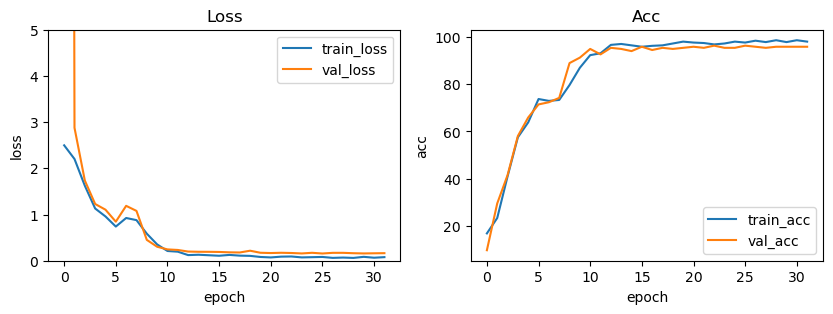

In [24]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(range(len(r_50_history['train_loss'])),r_50_history['train_loss'], label='train_loss')
plt.plot(range(len(r_50_history['train_loss'])),r_50_history['val_loss'], label='val_loss')
plt.ylim(0,5)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(r_50_history['train_loss'])), r_50_history['train_acc'], label='train_acc')
plt.plot(range(len(r_50_history['train_loss'])), r_50_history['val_acc'], label='val_acc')
plt.title('Acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [25]:
# optimizer = torch.optim.Adam(params=effi_net.parameters(), lr=0.001,momentum=0.9)
# scheduler = None
# e_history =train(effi_net, optimizer,criterion, train_loader, scheduler, device, 'efficient')


In [26]:
# optimizer = torch.optim.Adam(params=effi_net.parameters(), lr=0.001)
# scheduler = None
# r_101_history=train(resnet101,optimizer,criterion,train_loader, scheduler, device, 'resnet101')


예측하기

In [27]:
def inference(model,test_loader, device):
    model.to(device)
    model.eval()
    history = {}
    correct = 0
    total = 0
    class_correct = {classname : 0 for classname in classes}
    class_total = {classname : 0 for classname in classes}

    with torch.no_grad():
        for img, labels in tqdm(iter(val_loader)):
            img, labels = img.to(device), labels.to(device)

            outputs = model(img)

            # 가장 높은 것을 예측
            _, predicted = torch.max(outputs,1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for label, predict in zip(labels,predicted):
                if label == predict:
                    class_correct[classes[label]] +=1
                class_total[classes[label]] +=1
                
    val_acc = round(100* correct / total,1)
    for i in class_correct.keys():
        class_correct[i] = round(100*class_correct[i]/class_total[i],1)
    history['val_acc']=val_acc
    history['class_correct']=class_correct
    history['class_total']=class_total
    return history

In [33]:
import seaborn as sns

def make_acc_bar(history):
    colors = sns.color_palette('hls',len(history['class_correct']))
    fig = plt.figure(figsize=(6,5))
    plt.bar(history['class_correct'].keys(),history['class_correct'].values(), color=colors)
    plt.xticks(range(len(history['class_correct'])), rotation=90)
    fig.suptitle(f"Total Acc : {history['val_acc']:.2f}%", fontsize=10)
    return fig

100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


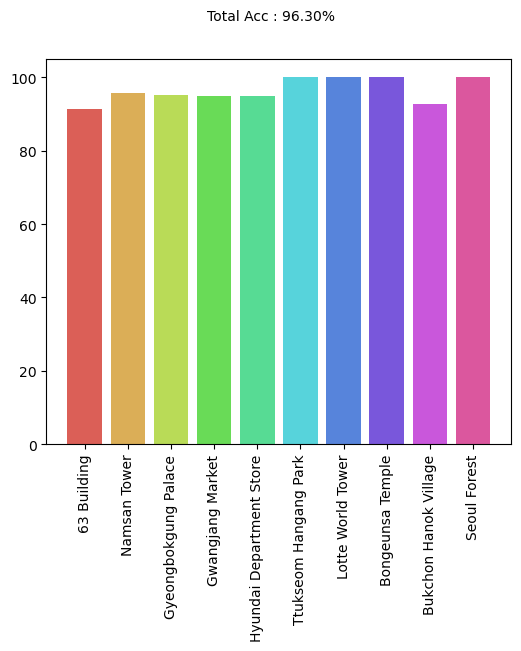

In [34]:
test_dataset = CustomDataset(val_img_path,None,train_mode=False,transforms=test_transform)
test_loader= DataLoader(test_dataset,batch_size =CFG['BATCH_SIZE'],shuffle=False,num_workers=0)

#checkpoint = torch.load('checkpoint/best_efficient.pth')
#effi_net.load_state_dict(checkpoint['model_state_dict'], strict=False)

checkpoint = torch.load('checkpoint/best_resnet50_963.pth')
resnet50.load_state_dict(checkpoint['model_state_dict'], strict=False)

#checkpoint = torch.load('checkpoint/best_resnet101.pth')
#resnet101.load_state_dict(checkpoint['model_state_dict'], strict=False)

history = inference(resnet50,test_loader,device)
fig = make_acc_bar(history)
